In [198]:
#imports
import pandas as pd
import numpy as np

#!pip install imbalanced-learn
#!pip install nltk
#!pip install langdetect

import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

from copy import deepcopy

# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer as wn
from nltk.corpus import wordnet
from nltk import pos_tag

from langdetect import detect_langs
import string # 
import re # regex
import itertools # flattening

nltk.download('punkt', quiet=True)
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# tensorflow?

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Viki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Viki/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Viki/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Viki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Viki/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
### Data Exploration

In [199]:
# reading in the csv file
df = pd.read_csv('data/train.csv')
# previewing the first 5 row of the dataset
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# checking the basic information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [200]:
# checking for null values
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [201]:
#df.dropna(inplace = True)

In [105]:
# previewing toxic comments
toxic = df.loc[df['toxic'] == 1]
toxic.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0
159554,ffbdbb0483ed0841,and i'm going to keep posting the stuff u dele...,1,0,1,0,1,0


In [106]:
# inspecting a selected comment
print(df.iloc[12]['comment_text'])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [75]:
# checking the toxicity for the selected comment
print(df.iloc[12][df.columns[2:]])

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: object


I will only will work with the toxic column, and focus on a binary classification model.

In [225]:
# checking value_counts for each column
values = df.iloc[:,2:].sum()
values

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

There are 15294 toxic comment in the dataframe, it is represents 9% of the total comments. Due to this inbalance, I will try SMOTE and RandomOverSampler later on when building the models.

In [202]:
# Define the function to remove non-English characters
import re
# remove any characters that are not english
regex = re.compile('[^A-Za-z0-9]+')
def remove_non_english(string):
    return regex.sub(' ', string)

# Use the apply method to apply the remove_non_english function to each value in the specified column
df['comment_text'] = df['comment_text'].apply(remove_non_english)

There are quite a lot of non-english text embeded in the english comments, and they indcrease the dimensionality once it's vectorized, so I decided to remove them.
The comment text also containing html links, what users used as referencing, so I will remove them with regex.

In [203]:
# Remove the links using the apply method
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'https?:\S+', '', x))

### Preprocessing

In [204]:
words = ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa'\
        'ƒüesareviƒá','aaaaaaaaaah','aaaaaaw','aaaaah','aaaah','aaaawwww','aaages','aaaghh','aaahhh','aaahs','길자비','길잡이','날짐승',\
         '날찜승','맛있다','잡아야','조선인민군', '척뉴넘','칠지도', '경상도','谢谢你','郭太后', '闘うカリスマ', \
         '陳胜吳廣', '電視劇', '青山内科', '飞天号航天服', '高句麗', '莱芜美景','話して下さい', '郭太后', '闘うカリスマ', '飞天号航天服', '電視劇', '高句麗', '경상도']

In [205]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
         stop_words = stopwords.words('english')
# #         # adding punctuations to stopwords
         stop_words += list(string.punctuation) 
         stop_words += word
        
        # save as parameters of Text preprocessor
        
         return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = wn()
        words = ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa'\
        'ƒüesareviƒá','aaaaaaaaaah','aaaaaaw','aaaaah','aaaah','aaaawwww','aaages','aaaghh','aaahhh','aaahs','길자비','길잡이','날짐승','날찜승','맛있다','잡아야','조선인민군', '척뉴넘','칠지도', '경상도',\
                '谢谢你','郭太后', '闘うカリスマ', '陳胜吳廣', '電視劇', '青山内科', '飞天号航天服', '高句麗','莱芜美景','話して下さい', '郭太后', '闘うカリスマ', '飞天号航天服', '電視劇', '高句麗', '경상도']
        stop_words = stopwords.words('english')
        # adding punctuations to stopwords
        stop_words += list(string.punctuation) 
        stop_words += word
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None

            
      # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words))]
        doc_norm = [tok.lower() for tok in doc_norm]
        #doc_norm = [tok for tok in doc_norm if tok not in stop_words]
        
        #remove mentions, hashtags, and urls, strip whitspace and breaks
        #doc_norm = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", doc_norm).strip().replace("\r", "").replace("\n", "").replace("\t", "")
        
        doc_norm = [tok for tok in doc_norm if (tok not in stop_words) & ((len(tok)>2) & (len(tok)< 20))]
        
        # selecting english words only
        #doc_norm = [tok for tok in doc_norm if detect_langs(tok)[0].lang == 'en']
        
        doc_norm = [tok for tok in doc_norm if (len(tok)>2)]
        doc_norm = [tok for tok in doc_norm if (len(tok)< 15)]
        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [25]:
# for word in words:
#     languages = detect_langs(word)
#     if languages[0].lang == "en":
#         filtered_words.append(word)
        
# filtered_words = [word for word in words if detect_langs(word)[0].lang == "en"]

In [206]:
#targets= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = df['comment_text']
y = df['toxic']

In [161]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [208]:
# Initiating the textPreprocessor
proc = TextPreprocessor()

# fiting and transforming the train, validation and transforming the test
X_train_proc =proc.fit_transform(X_train)
X_val_proc = proc.fit_transform(X_val)
X_test_proc = proc.transform(X_test)

In [209]:
# checking the train after transformation
X_train_proc.head()

33538     ease restriction baby step understand post tal...
147984    page look good thank sign name date time stamp...
17011     hit tlip google accord discussion bay current ...
156968             thank response answer question perfectly
49299       image jpg thanks head restore nsd tag chit chat
Name: comment_text, dtype: object

The preprocessing lowercased all the words, removed numbers, removed stopwords and punctuation. Also in the preprocessing I used lemmatization with pos tagger.

In [210]:
#count vectorizer
prc_steps = [('countvec', CountVectorizer())]
preprocess_pipeline = Pipeline(prc_steps)

In [211]:
preprocess_pipeline

Pipeline(steps=[('countvec', CountVectorizer())])

In [212]:
X_tr_proc = preprocess_pipeline.fit_transform(X_train_proc)

In [ ]:
# freqDist

In [213]:
feature_names = preprocess_pipeline[
     'countvec'].get_feature_names_out()

new_df = pd.DataFrame(X_tr_proc.toarray(), columns = feature_names)

In [214]:
new_df

,aa,aaaaaaaaczy,aaai,aaajade,aaand,aaaww,aab,aaba,aaberg,aac,...,zzaroc,zzem,zzet,zzuuzz,zzy,zzyzwicz,zzz,zzzz,zzzzz,zzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


By removing the non english words reduced the dimensionality from 200k to 114k. Reducing dimensionality is important to make sure the model will not overfit.

In [124]:
#korean = df[df['comment_text'].str.contains('莱芜美景')] #날짐승')]
#korean['comment_text']

137998    "the legend of LaiWu Goddess.""莱芜美景"" 澄海区人民政府网...
Name: comment_text, dtype: object

In [216]:
# checking the original imbalance
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

0    0.904126
1    0.095874
Name: toxic, dtype: float64

### Model1 - MultinomialNB

In [217]:
pipe = deepcopy(preprocess_pipeline)
pipe.steps.append(('multinb', MultinomialNB()))
pipe.steps

[('countvec', CountVectorizer()), ('multinb', MultinomialNB())]

In [218]:
pipe.fit(X_train_proc, y_train)

Pipeline(steps=[('countvec', CountVectorizer()), ('multinb', MultinomialNB())])

In [92]:
#predict_proba = pipe.predict_proba(X_test_proc)

In [93]:
#predict_proba[:, 1]

array([4.09398357e-05, 1.72247448e-04, 3.72860684e-04, ...,
       1.45252257e-09, 1.26663225e-09, 2.06240876e-08])

In [219]:
transformed_test = proc.transform(X_test)

y_pred = pipe.predict(transformed_test) # automatically applies transforms and predicts on test

In [220]:
recall_score(y_test, y_pred)

0.6162144491663942

In [221]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28856
           1       0.84      0.62      0.71      3059

    accuracy                           0.95     31915
   macro avg       0.90      0.80      0.84     31915
weighted avg       0.95      0.95      0.95     31915



In [222]:
roc_auc_score(y_test, y_pred)

0.8019040086142478

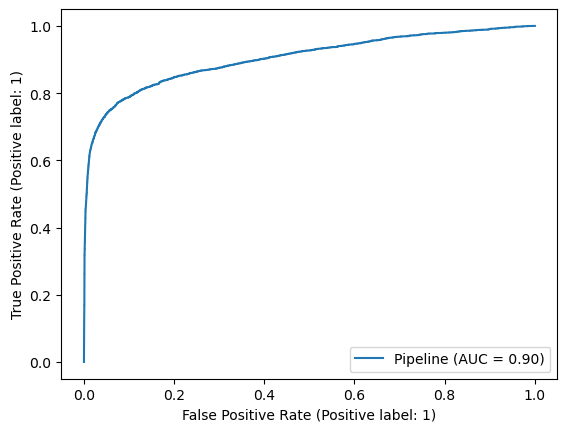

In [223]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe, X_test_proc, y_test) # changed transformed_test to X_test_proc

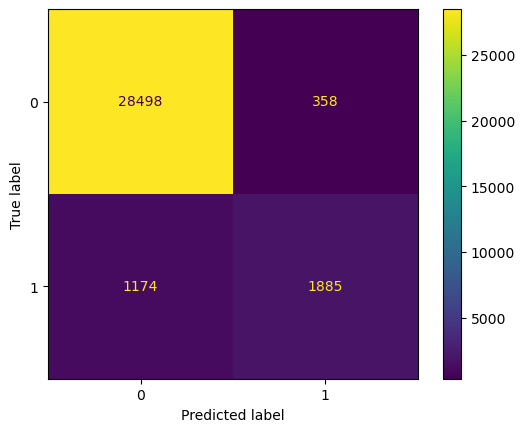

In [224]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe, X_test_proc, y_test);

In [196]:
# gridsearch for multinomialNB
param_grid = {
    'countvec__ngram_range': [(1, 1), (1, 2), (1,3)],
    'multinb__alpha': [1, 1e-1, 1e-2, 0.5, 10],
    'multinb__fit_prior': [True, False]
}

clf = GridSearchCV(estimator = pipe, param_grid = param_grid, cv=5, scoring='recall', n_jobs=-1)

In [197]:
clf.fit(X_train_proc, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvec', CountVectorizer()),
                                       ('multinb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'multinb__alpha': [1, 0.1, 0.01, 0.5, 10],
                         'multinb__fit_prior': [True, False]},
             scoring='recall')

In [50]:
clf.best_params_

{'countvec__ngram_range': (1, 1),
 'multinb__alpha': 0.1,
 'multinb__fit_prior': False}

In [56]:
MultinomialNB??

In [57]:
# reruning to model with the best params
pipe1 = deepcopy(preprocess_pipeline)
pipe1.steps.append(('multinb', MultinomialNB(
                 alpha = 0.1,
                 fit_prior = False
)))
pipe1.steps

[('countvec', CountVectorizer()),
 ('multinb', MultinomialNB(alpha=0.1, fit_prior=False))]

In [58]:
pipe1.fit(X_train_proc, y_train)

Pipeline(steps=[('countvec', CountVectorizer()),
                ('multinb', MultinomialNB(alpha=0.1, fit_prior=False))])

In [59]:
transformed_test = proc.transform(X_test)

y_pred = pipe1.predict(transformed_test) # automatically applies transforms and predicts on test

In [60]:
recall_score(y_test, y_pred)

0.8077803203661327

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     28856
           1       0.56      0.81      0.66      3059

    accuracy                           0.92     31915
   macro avg       0.77      0.87      0.81     31915
weighted avg       0.94      0.92      0.93     31915



In [62]:
roc_auc_score(y_test, y_pred)

0.8702229852454451

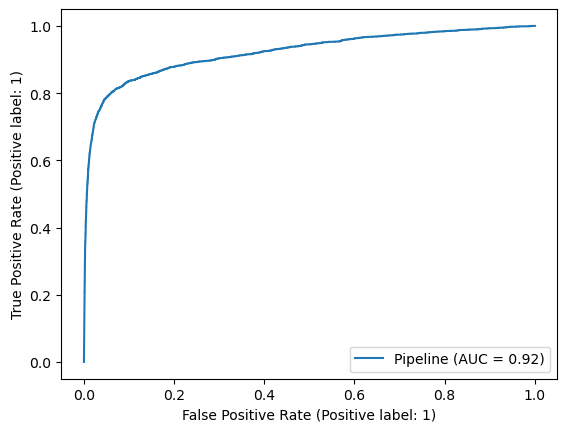

In [63]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe1, X_test_proc, y_test)

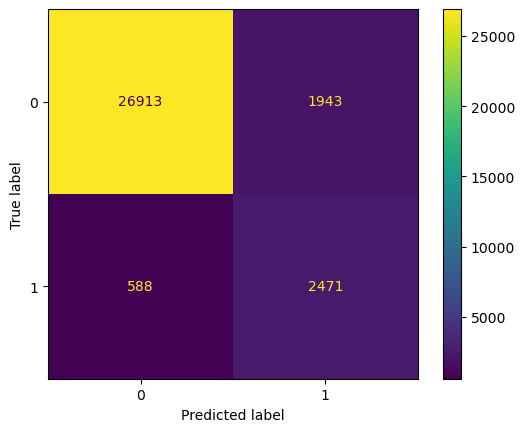

In [64]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe1, X_test_proc, y_test);

In [78]:
# random forest 

pipe1.steps.pop(-1)

('multinb', MultinomialNB())

In [79]:
pipe1.steps.append(('forest', RandomForestClassifier(random_state = 46,
                                                  criterion = 'entropy',
                                                  max_depth = 3,
                                                  min_samples_leaf = 50,
                                                  n_estimators = 50
)))
pipe1.steps

[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 3))),
 ('smote', SMOTE()),
 ('forest',
  RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=50,
                         n_estimators=50, random_state=46))]

In [80]:
pipe1.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 3))),
                ('smote', SMOTE()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=50, n_estimators=50,
                                        random_state=46))])

In [81]:
pipe1.score(X_train_proc, y_train)
pipe1.score(X_test_proc,y_test)

0.5837067209775968

In [82]:
y_pred3 = pipe1.predict(X_test_proc)


In [83]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.96      0.56      0.71     28856
           1       0.16      0.78      0.27      3059

    accuracy                           0.58     31915
   macro avg       0.56      0.67      0.49     31915
weighted avg       0.88      0.58      0.67     31915



In [84]:
roc_auc_score(y_test, y_pred3)

0.6734917419300109

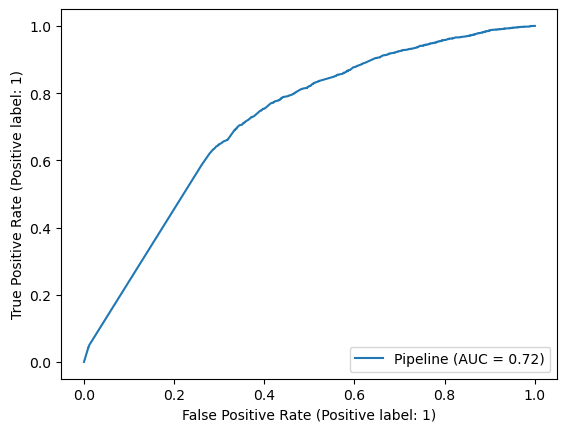

In [85]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe1, X_test_proc, y_test)

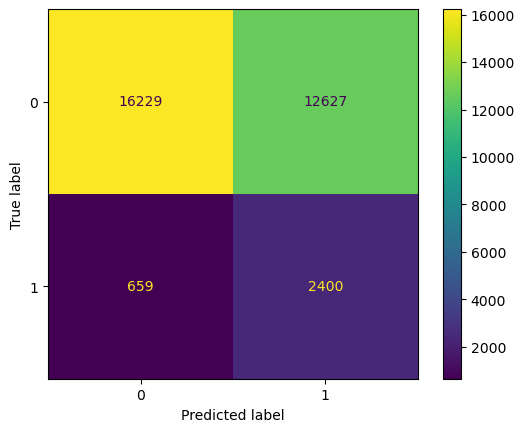

In [86]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe1, X_test_proc, y_test);

### Model2

In [65]:
### Model 2 - try tf-idf vectorizer
TfidfVectorizer??
# model running slow - decrease min_df
# accuracy is not good - increase 

In [48]:
#count vectorizer
# prc_steps = [('tfidf', TfidfVectorizer(min_df = 0.05, max_df = 0.95))]
# preprocess_pipeline = Pipeline([prc_steps,
#                               ('smote', SMOTE(random_state= 40))])

In [66]:
pipe1 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05,ngram_range=(1, 3))),
                 ('smote', SMOTE()), 
                 ('multinb', MultinomialNB())])

In [67]:
pipe1.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 3))),
                ('smote', SMOTE()), ('multinb', MultinomialNB())])

In [68]:
pipe1.score(X_train_proc, y_train)
pipe1.score(X_test_proc,y_test)

0.6888610371298762

In [69]:
y_pred = pipe1.predict(X_test_proc)


In [70]:
acc = accuracy_score(y_test, y_pred, normalize= True)
acc

0.6888610371298762

In [71]:
rec = recall_score(y_test, y_pred)
rec

0.4426283099051978

In [72]:
y_train.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.81     28856
           1       0.14      0.44      0.21      3059

    accuracy                           0.69     31915
   macro avg       0.53      0.58      0.51     31915
weighted avg       0.85      0.69      0.75     31915



In [75]:
roc_auc_score(y_test, y_pred)

0.5787961344369349

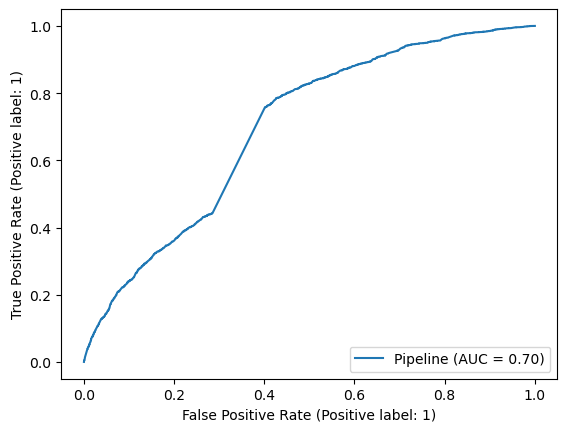

In [76]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe1, X_test_proc, y_test)

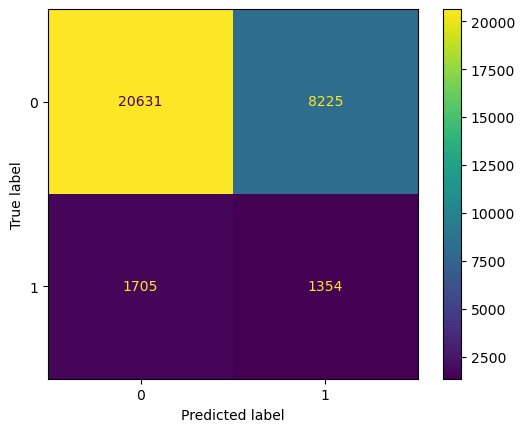

In [77]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe1, X_test_proc, y_test);

Appying SMOTE on the Multinomial Naive Bayes model did improve the number of false negatives from 26590 to 9667, that is more then 10k decrease. The AUC decreased from 62% to 54%


### Model3 - RandomForest - SMOTE

In [218]:
# changing the Multinomial Naive Bayes to Random Forest

pipe1.steps.pop(-1)
pipe1.steps.append(['forest', RandomForestClassifier(random_state = 40)])

In [219]:
pipe1.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('smote', SMOTE()),
                ['forest', RandomForestClassifier(random_state=40)]])

In [220]:
pipe1.score(X_train_proc, y_train)
pipe1.score(X_test_proc,y_test)

0.736550211499295

In [221]:
y_pred3 = pipe1.predict(X_test_proc)


In [222]:
acc = accuracy_score(y_test, y_pred3, normalize= True)

In [223]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     28856
           1       0.20      0.60      0.30      3059

    accuracy                           0.74     31915
   macro avg       0.57      0.67      0.57     31915
weighted avg       0.88      0.74      0.79     31915



In [230]:
roc_auc_score(y_test, y_pred3)

0.6747238182756948

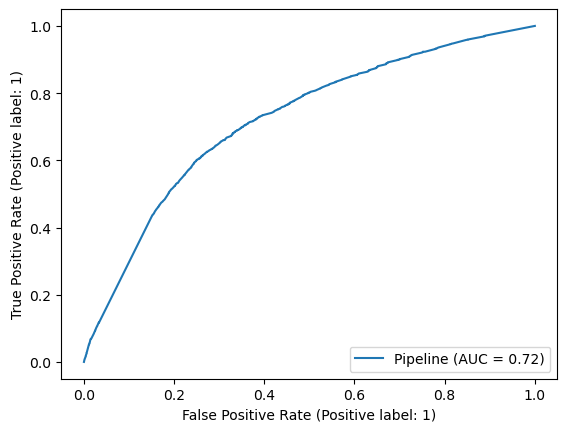

In [231]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe1, X_test_proc, y_test)

to Optimize the hyperparameters for the randomForest I will run a gridSearchCv to get the best parameters 

In [226]:
# Performing a grid search for our random forest
import time

start = time.time()

rf_params = param_grid = {'forest__criterion': ['gini', 'entropy'], 
                          'forest__n_estimators': [30, 50, 150], 
                          'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__max_depth': [3, 5, 7]}

rf_grid_pipe = GridSearchCV(estimator = pipe1, param_grid = rf_params, scoring = 'recall', cv = 3, n_jobs = -1)

end = time.time()

print(end - start)
# try accuracy insted of recall

0.01417994499206543


In [72]:
# try random search - grid search is too slow
# rf_random = RandomizedSearchCV(rf, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
# model_random = rf_random.fit(X,y)

In [227]:
# Fitting the training data
start = time.time()

rf_grid_pipe.fit(X_train_proc, y_train)

end = time.time()
print(end - start)

174.79809594154358


In [228]:
# Returning the best parameters as a result of the grid search
start = time.time()

rf_grid_pipe.best_params_

end = time.time()
print(end - start)

2.3126602172851562e-05


In [229]:
rf_grid_pipe.best_params_

{'forest__criterion': 'entropy',
 'forest__max_depth': 3,
 'forest__min_samples_leaf': 50,
 'forest__n_estimators': 50}

In [76]:
# {'forest__criterion': 'gini',
#  'forest__max_depth': 3,
#  'forest__min_samples_leaf': 2,
#  'forest__n_estimators': 30}

In [77]:
# creating a model with the best parameters

In [232]:
pipe3 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                 ('smote', SMOTE()), 
                 ('forest', RandomForestClassifier(random_state = 43,
                                                  criterion = 'entropy',
                                                  max_depth = 3,
                                                  min_samples_leaf = 50,
                                                  n_estimators = 50))])

In [233]:
# Fitting the model with the best params
pipe3.fit(X_train_proc, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('smote', SMOTE()),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=50,
                                        n_estimators=50, random_state=43))])

In [234]:
pipe3.score(X_train_proc, y_train)
pipe3.score(X_test_proc,y_test)

0.5839573868087107

In [236]:
y_pred4 = pipe3.predict(X_test_proc)

In [237]:
acc = accuracy_score(y_test, y_pred4, normalize= True)


In [238]:
print(classification_report(y_test, y_pred4)) # leaf - 20

              precision    recall  f1-score   support

           0       0.96      0.56      0.71     28856
           1       0.16      0.78      0.26      3059

    accuracy                           0.58     31915
   macro avg       0.56      0.67      0.49     31915
weighted avg       0.88      0.58      0.67     31915



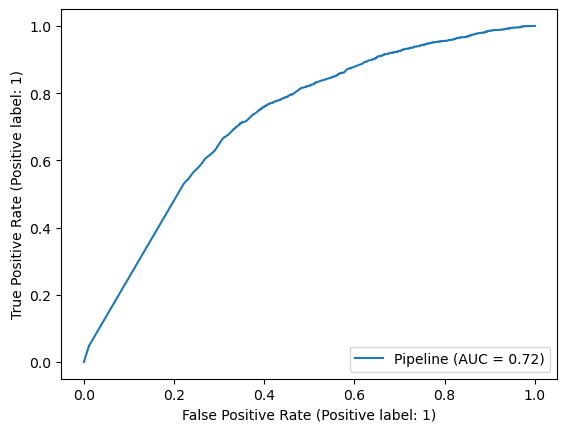

In [239]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe3, X_test_proc, y_test)

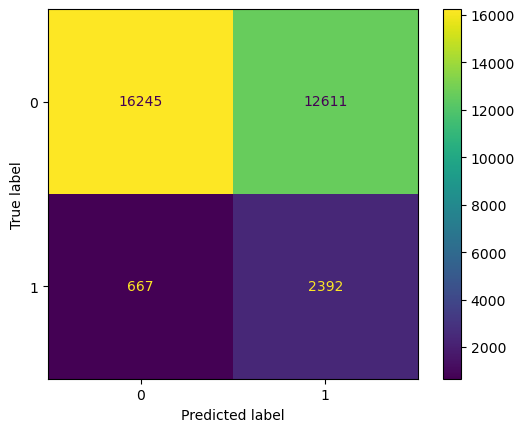

In [240]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe3, X_test_proc, y_test);

### Model4 - RandomForest - RandomOverSampler


In [86]:
#('over',RandomOverSampler(random_state=42, sampling_strategy='minority'))

In [276]:
pipe4 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                 ('over',RandomOverSampler(random_state=46)), 
                 ('forest', RandomForestClassifier(random_state = 46,
                                                  criterion = 'entropy',
                                                  max_depth = 3,
                                                  min_samples_leaf = 50,
                                                  n_estimators = 50))])

In [277]:
pipe4.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('over', RandomOverSampler(random_state=46)),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=50, n_estimators=50,
                                        random_state=46))])

In [278]:
pipe4.score(X_train_proc, y_train)
pipe4.score(X_test_proc,y_test)

0.5783800720664265

In [279]:
y_pred5 = pipe4.predict(X_test_proc)

In [280]:
acc = accuracy_score(y_test, y_pred4, normalize= True)

In [281]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.96      0.56      0.70     28856
           1       0.16      0.78      0.26      3059

    accuracy                           0.58     31915
   macro avg       0.56      0.67      0.48     31915
weighted avg       0.88      0.58      0.66     31915



In [282]:
roc_auc_score(y_test, y_pred5)

0.6693770831987093

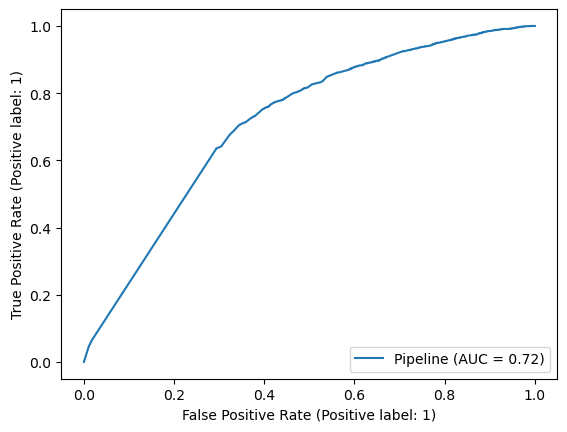

In [283]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe4, X_test_proc, y_test)

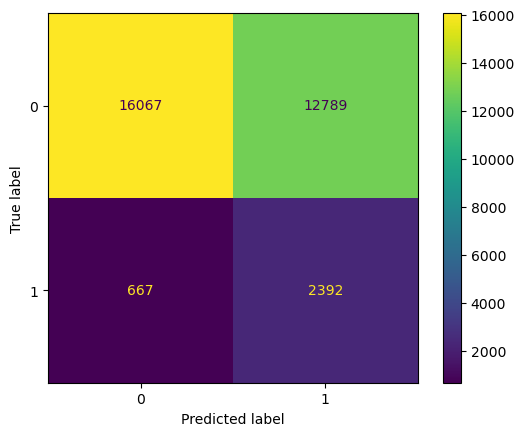

In [284]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe4, X_test_proc, y_test);

### Model5 - XGBoost


In [285]:
pipe5 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                   ('over', RandomOverSampler(random_state = 50)),
                   ('xgb', XGBClassifier(random_state = 50))])

In [286]:
# Performing a grid search for our XGBoost
xgb_params = {
    'xgb__gamma': [0.5, 1, 5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__n_estimators': [50, 100, 150, 200],
}

xgb_grid = GridSearchCV(estimator = pipe5, param_grid = xgb_params, scoring = 'recall', cv = 3)

In [287]:
# Fitting the training data
xgb_grid.fit(X_train_proc, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.95,
                                                        min_df=0.05)),
                                       ('over',
                                        RandomOverSampler(random_state=50)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      featu...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=50, ...))]),
             param_grid={'xgb__gamma': [0.5, 1, 5],
                         'xgb__learning_rate': [0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__min_child_weight': [1, 5, 10],
                         'xgb__n_estimators': [50, 100, 150, 200]},
             scoring='recall')

In [288]:
# Returning the best parameters as a result of the grid search
xgb_grid.best_params_

{'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 50}

In [100]:
# {'xgb__gamma': 5,
#  'xgb__learning_rate': 0.1,
#  'xgb__max_depth': 3,
#  'xgb__min_child_weight': 10,
#  'xgb__n_estimators': 50}

In [289]:
# Creating a new pipeline that implements the best parameters
pipe6 = Pipeline(steps = ([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                           ('over', RandomOverSampler(random_state = 51)),
                           ('xgb', XGBClassifier(random_state = 51,
                                                 gamma = 0.5,
                                                 learning_rate = 0.1,
                                                 max_depth = 3,
                                                 min_child_weight = 10,
                                                 n_estimators = 50))]))

In [290]:
# Fitting the training data with the updated pipeline
pipe6.fit(X_train_proc, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('over', RandomOverSampler(random_state=51)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.5, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=10,
                               missing=nan, monotone_constraints='()',
                               n_estimators=50, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=51, ...))])

In [291]:
y_pred6 = pipe6.predict(X_test_proc)

In [292]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.96      0.58      0.72     28856
           1       0.17      0.80      0.28      3059

    accuracy                           0.60     31915
   macro avg       0.57      0.69      0.50     31915
weighted avg       0.89      0.60      0.68     31915



In [293]:
roc_auc_score(y_test, y_pred6)

0.6876365631717702

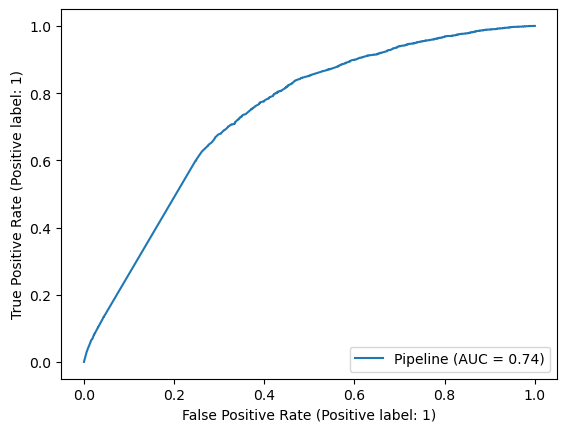

In [294]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe6, X_test_proc, y_test)

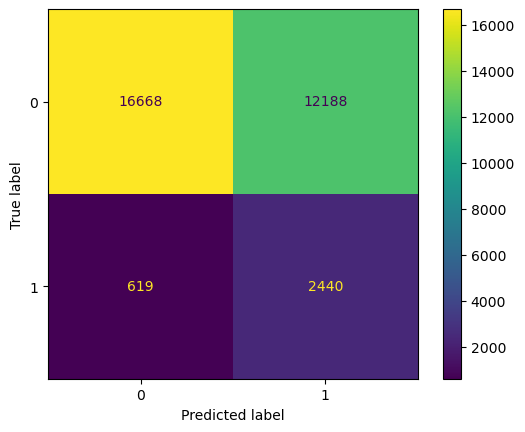

In [295]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe6, X_test_proc, y_test);

### Ensemble method - Stacking

In [108]:
# pp = ColumnTransformer(transformers=[
#     ('num', numTrans, X_num),
#     ('cat', catTrans, X_cat)
# ])

In [109]:
# estimators = [
#     ('lr', LinearRegression()),
#     ('knn', KNeighborsRegressor()),
#     ('rt', DecisionTreeRegressor())
# ]
# # linear regression makes predictions and next if fed into kneighbors and those predictions are fed into decisiontree
# sr = StackingRegressor(estimators)


# final_p = Pipeline([('preprocess', pp), ('model', sr)])


# final_p.fit(X_train, y_train)

In [155]:
estimators = [
    ('multinb', MultinomialNB(alpha = 0.1,
                             fit_prior = False)),
    ('forest', RandomForestClassifier(criterion = 'entropy',
                                     max_depth = 3,
                                     min_samples_leaf = 50,
                                     n_estimators = 50)),
    ('xgb', XGBClassifier(gamma = 0.5,
                         learning_rate = 0.1,
                         max_depth = 3,
                         min_child_weight = 1,
                         n_estimators = 50))
]

In [156]:
sr = StackingClassifier(estimators)


In [157]:
pipe7 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                  ('ens', sr)])

In [158]:
pipe7.fit(X_train_proc, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('ens',
                 StackingClassifier(estimators=[('multinb', MultinomialNB()),
                                                ('forest',
                                                 RandomForestClassifier(max_depth=3,
                                                                        min_samples_leaf=5,
                                                                        n_estimators=50)),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=Non...
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=50,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))])

In [167]:
pipe7.score(X_test_proc, y_test)

0.9911953626821244

In [168]:
y_pred7 = pipe7.predict(X_test_proc)

In [169]:
roc_auc_score(y_test, y_pred7)

0.5

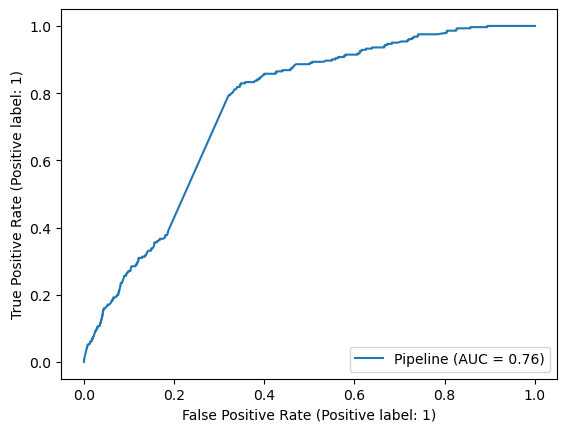

In [170]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe7, X_test_proc, y_test)

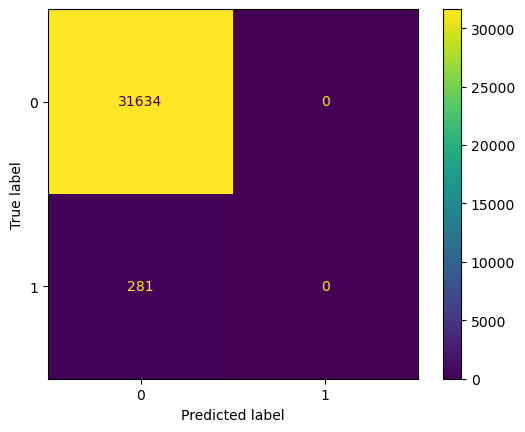

In [171]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7, X_test_proc, y_test);